In [1]:
import numpy as np 
import pandas as pd 

import os

In [2]:
import tensorflow as tf

train_folder = "./input/cityscapes_data/train"
test_folder = "./input/cityscapes_data/val"


train_onlyfiles = [f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]
test_onlyfiles = [f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]


print("Working with {0} train images".format(len(train_onlyfiles)))
print("Working with {0} test images".format(len(test_onlyfiles)))

Working with 2975 train images
Working with 500 test images


In [3]:
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_files = []
test_files = []
train_img_arr = []
test_img_arr = []

i=0
for _file in train_onlyfiles:
    train_files.append(_file)
for _file in test_onlyfiles:
    test_files.append(_file)
    

for _file in train_files:
    img = load_img(train_folder + "/" + _file)  # this is a PIL image
    img.thumbnail((256, 512)) #비율에 맞게 사이즈를 조절
    # Convert to Numpy Array
    x = img_to_array(img) 
    train_img_arr.append(x)
for _file in test_files:
    img = load_img(test_folder + "/" + _file)  # this is a PIL image
    img.thumbnail((256, 512))
    # Convert to Numpy Array
    x = img_to_array(img) 
    test_img_arr.append(x)

In [4]:
train_arr = np.array(train_img_arr)
test_arr = np.array(test_img_arr)

In [5]:
x_train = train_arr[:,:,0:128,:]
y_train = train_arr[:,:,128:256,:]
x_test = test_arr[:,:,0:128,:]
y_test = test_arr[:,:,128:256,:]

In [6]:
x_train = x_train/255
y_train = y_train/255
x_test = x_test/255
y_test = y_test/255

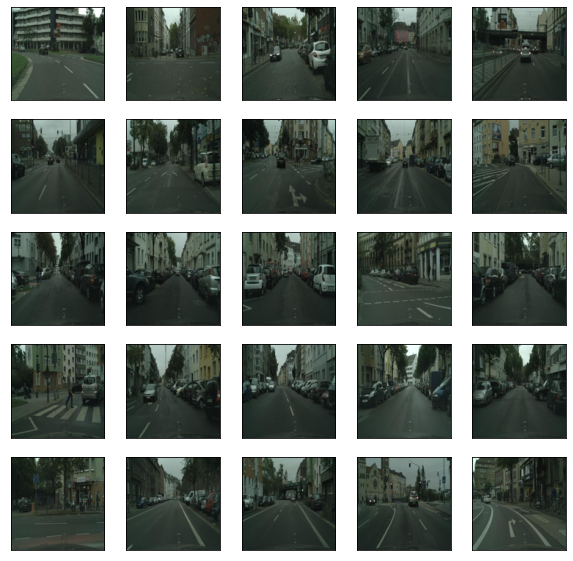

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()

In [9]:
from keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Conv2DTranspose,concatenate

In [10]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# # instantiating the model in the strategy scope creates the model on the TPU
# with tpu_strategy.scope():
inputs = Input((128, 128, 3))
start_neurons = 16
dropout_rate = 0.4
conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(inputs)
conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)
pool1 = Dropout(dropout_rate)(pool1)

conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)
pool2 = Dropout(dropout_rate)(pool2)

conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)
pool3 = Dropout(dropout_rate)(pool3)

conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
pool4 = MaxPooling2D((2, 2))(conv4)
pool4 = Dropout(dropout_rate)(pool4)
    
conv5 = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
conv5 = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(conv5)
pool5 = MaxPooling2D((2, 2))(conv5)
pool5 = Dropout(dropout_rate)(pool5)

# Middle
convm = Conv2D(start_neurons * 32, (3, 3), activation="relu", padding="same")(pool5)
convm = Conv2D(start_neurons * 32, (3, 3), activation="relu", padding="same")(convm)
    
deconv5 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
uconv5 = concatenate([deconv5, conv5])
uconv5 = Dropout(dropout_rate)(uconv5)
uconv5 = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(uconv5)
uconv5 = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(uconv5)

deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv5)
uconv4 = concatenate([deconv4, conv4])
uconv4 = Dropout(dropout_rate)(uconv4)
uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
uconv3 = concatenate([deconv3, conv3])
uconv3 = Dropout(dropout_rate)(uconv3)
uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
uconv2 = concatenate([deconv2, conv2])
uconv2 = Dropout(dropout_rate)(uconv2)
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    
deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
uconv1 = concatenate([deconv1, conv1])
uconv1 = Dropout(dropout_rate)(uconv1)
uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
outputs = Conv2D(3, (1,1), padding="same", activation="sigmoid")(uconv1)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [14]:
history = model.fit(x_train, y_train, epochs=40, 
                    validation_data=(x_test, y_test))

Epoch 1/40
93/93 [==============================] - 276s 3s/step - loss: 0.5648 - accuracy: 0.6833 - val_loss: 0.5614 - val_accuracy: 0.7345
Epoch 2/40
93/93 [==============================] - 290s 3s/step - loss: 0.5644 - accuracy: 0.6829 - val_loss: 0.5608 - val_accuracy: 0.6140
Epoch 3/40
93/93 [==============================] - 279s 3s/step - loss: 0.5636 - accuracy: 0.6906 - val_loss: 0.5602 - val_accuracy: 0.7266
Epoch 4/40
93/93 [==============================] - 291s 3s/step - loss: 0.5633 - accuracy: 0.6839 - val_loss: 0.5603 - val_accuracy: 0.7190
Epoch 5/40
93/93 [==============================] - 284s 3s/step - loss: 0.5631 - accuracy: 0.6826 - val_loss: 0.5600 - val_accuracy: 0.7005
Epoch 6/40
93/93 [==============================] - 275s 3s/step - loss: 0.5626 - accuracy: 0.6806 - val_loss: 0.5596 - val_accuracy: 0.7199
Epoch 7/40
93/93 [==============================] - 271s 3s/step - loss: 0.5625 - accuracy: 0.6900 - val_loss: 0.5610 - val_accuracy: 0.6619
Epoch 8/40
93

In [15]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test)
predictions[0].shape

(128, 128, 3)

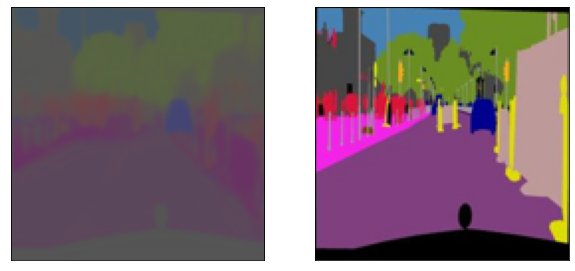

In [16]:
plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(predictions[2])

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(y_test[2])

plt.show()

In [27]:
test_images_path = "./data/googling"

test_images_files = [f for f in os.listdir(test_images_path) if os.path.isfile(os.path.join(test_images_path, f))]

test_images_files

['king_street.jpg', 'street_busan.jpg', 'street_image.png']

In [36]:
from skimage.transform import resize

test_images = []
# test_images_files = []

for _file in test_images_files:
    img = load_img(test_images_path + "/" + _file)  # this is a PIL image
    img.thumbnail((256, 256)) #비율에 맞게 사이즈를 조절
    # Convert to Numpy Array
    x = img_to_array(img)
    
    x = resize(x, (128, 128))
    
    test_images.append(x)

test_images = np.array(test_images)
test_images = test_images/255

In [37]:
test_images[1].shape

(128, 128, 3)

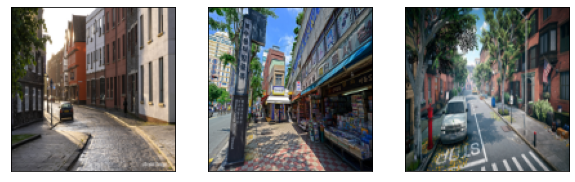

In [38]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])
plt.show()

In [39]:
predictions_test = probability_model.predict(test_images)

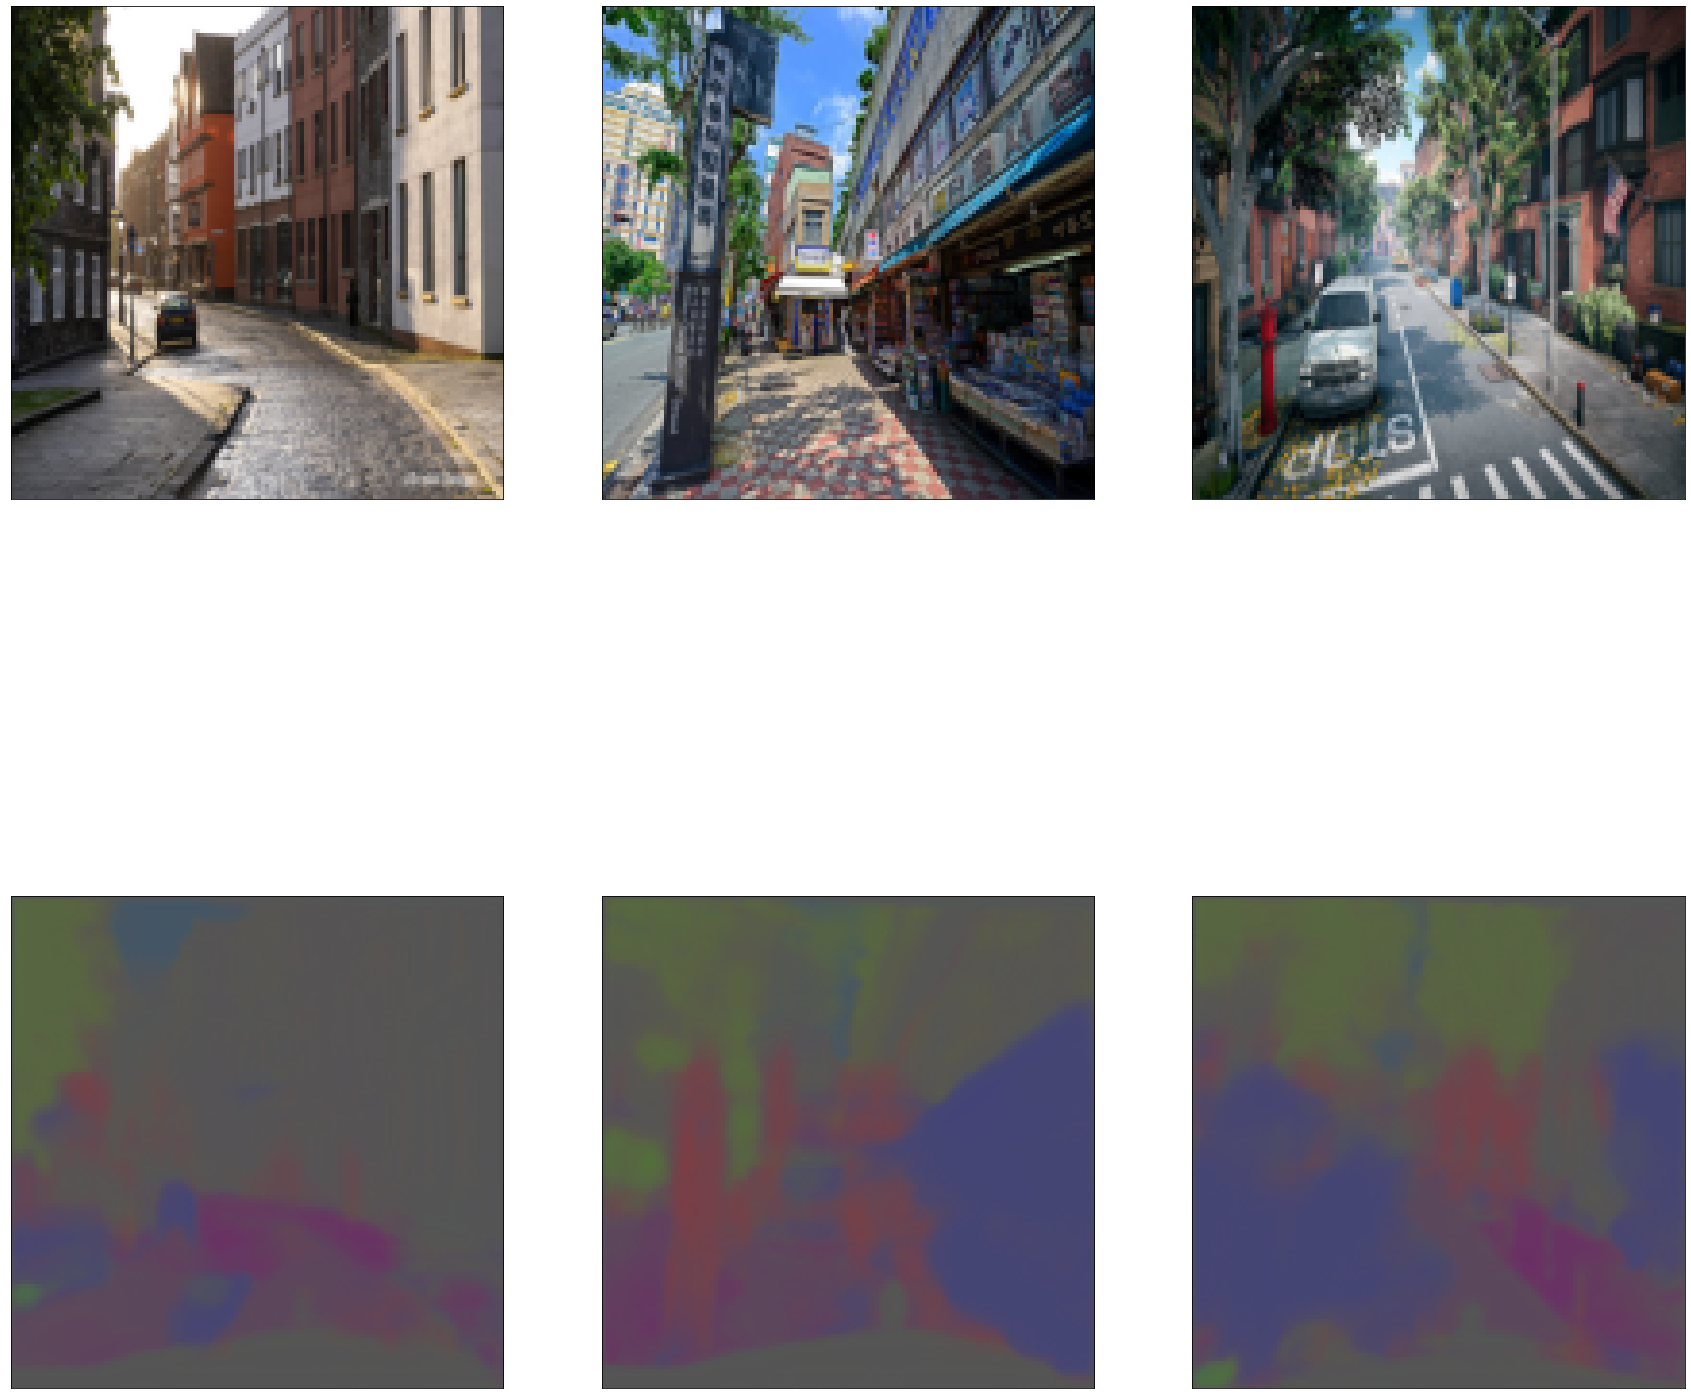

In [43]:
plt.figure(figsize=(30,30))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])
    
for i in range(3):
    plt.subplot(2,3,i+4)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predictions_test[i])
plt.show()